#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

Цель исследования: Создать модель со значением метрики RMSE не больше 48.

Ход исследования:

- Подготовка данных
- Анализ данных
- Обучение моделей
- Проверка на тестовой выборке
- Общий вывод

## Подготовка

In [1]:
# импорт библиотек
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics import tsaplots
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import (
    cross_validate, 
    train_test_split,
    RandomizedSearchCV,
    TimeSeriesSplit
)
from sklearn.metrics import mean_squared_error

In [2]:
# загрузка данных
try:
    data = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'], index_col=['datetime'])
except:
    data = pd.read_csv('https://code.s3.yandex.net//datasets/taxi.csv', parse_dates=['datetime'], index_col=['datetime'])

In [3]:
# первые строки датафрейма
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
# информация о датафрейме
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
# описание столбцов
data.describe().T

,count,mean,std,min,25%,50%,75%,max
num_orders,26496.0,14.070463,9.21133,0.0,8.0,13.0,19.0,119.0


In [6]:
# проверка ряда на монотонность
data.index.is_monotonic

True

Т.к. нам нужно будет делать предсказания на каждый следующий час, сделаем ресемплирование по одному часу. Количество заказов при агрегировании будет суммироваться.

In [7]:
data = data.resample('1H').sum()
print(f'Размер нового датафрейма: {data.shape}')

Размер нового датафрейма: (4416, 1)


**Вывод:**
В данной части исследования мы провели обзор данных. Датасет состоит из двух столбцов один из которых `datetime` - отметки времени (1 марта - 31 августа), которые мы сделали индексами, а второй столбец `num_orders` - целевой признак содержащий количество заказов, который по итогу нам нужно будет спрогнозировать. 

В датафреме отсутствуют пропуски, также можно приметить что аномалии также отсутствуют.

Дата и время расположены в хронологическом порядке. Для построения модели мы провели ресемплирование по одному часу с суммированием целевого признака. Колмчество строк уменьшилось до 4416. 

## Анализ

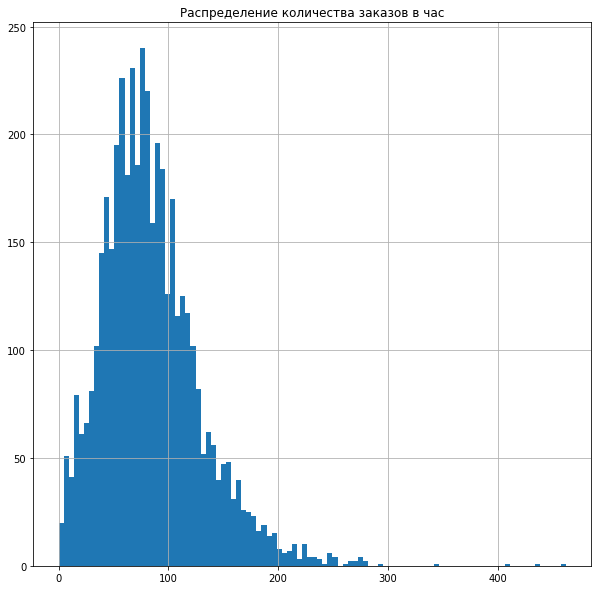

In [8]:
# распределение количества заказов
data['num_orders'].hist(figsize = (10,10), bins=100)
plt.title('Распределение количества заказов в час')
plt.show()

Количество заказов распределено неравномерно. Основная часть значений находится в пределах от 0 до 150 заказов в час

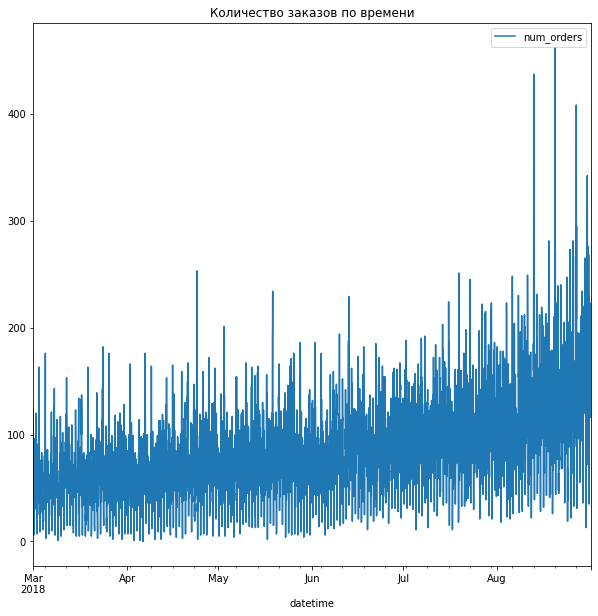

In [9]:
data.plot(figsize=(10,10))
plt.title('Количество заказов по времени')
plt.show()

На графике можно заметить, что он постепенно движется вверх, что говорит об увеличении количества заказов к концу лета. Видно огромное количество колебаний, количество заказов скачет от часа к часу.

Создадим новый признак "скользящее среднее". Он задает общий тренд ряда. На графике мы увидим уменьшение амплитуды колебаний. Чтобы предотвратить утечку целевого признака, мы не будем включать текущее значение ряда с помощью shift().

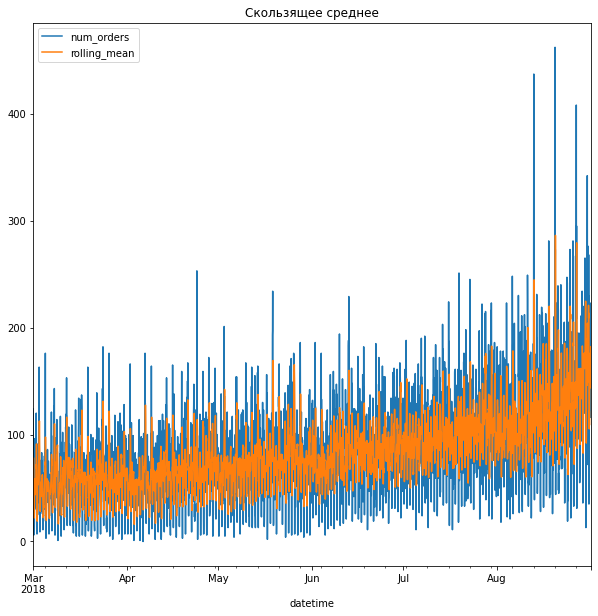

In [10]:
# скользящее среднее (не учитываем текущее значение)
data['rolling_mean'] = data['num_orders'].shift().rolling(5).mean()
data.plot(figsize=(10,10))
plt.title('Скользящее среднее')
plt.show()

Временной ряд и график скользящего среднего действительно сгладился относительно первоначального. Увеличение количества заказов ближе к концу лета является трендом.

Проанализируем тренд и сезонность более подробно.

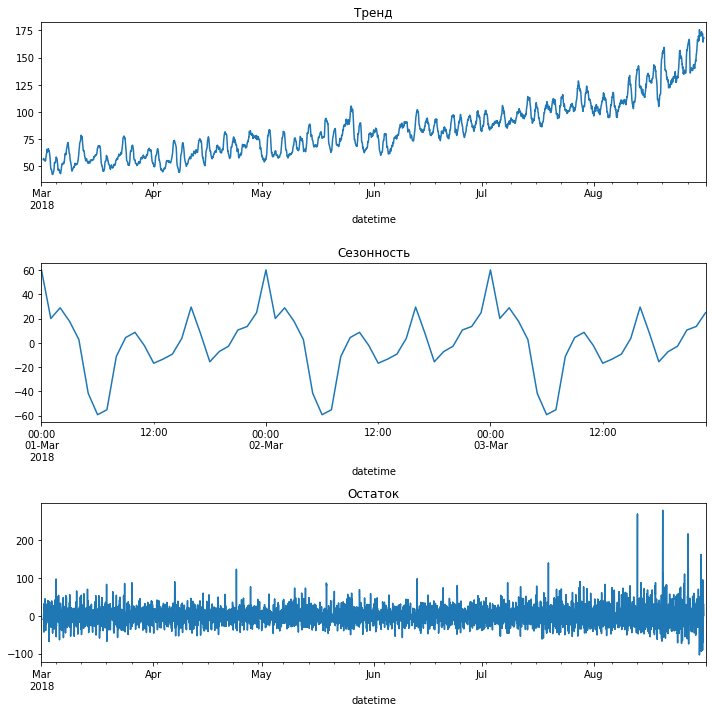

In [11]:
# раскладываем временной ряд
decomposed = seasonal_decompose(data['num_orders'])
plt.figure(figsize=(10, 10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
# проверяем сезонную составляющую в первые два дня
decomposed.seasonal[:72].plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток')
plt.tight_layout()

Действительно, видим что увеличение количества заказов в час под конец лета является трендом.

График сезонной составляющей говорит о том, что количество заказов увеличивается с 6 утра, потом в обед затишье и снова пик с 15 до 18. И еще видим пик в полночь, это объясняется отсутствием или малым количеством общественного транспорта в это время.

Видим увеличение дисперсии в Августе на графике остатков. Эти данные будет сложнее предсказать. Причем, эти данные попадут в тестовую выборку. Следует ожидать разброса между метриками при кросс-валидации и тестировании.

Ресеплируем ряд по дням и проверим недельную сезонность. 

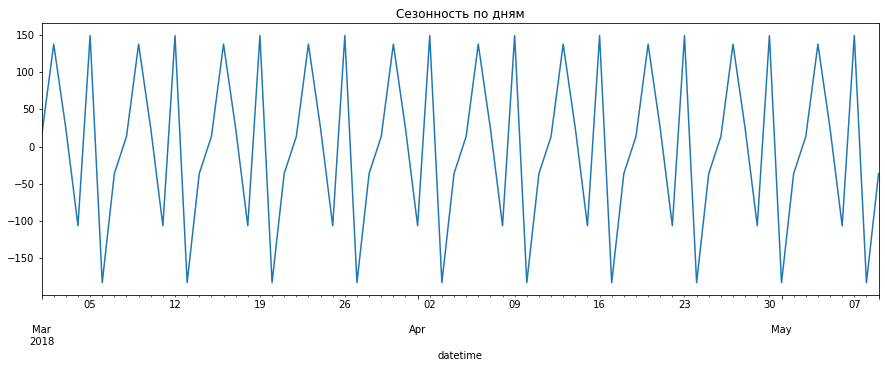

In [12]:
data_day = data['num_orders'].resample('1D').sum()
# раскладываем временной ряд
decomposed_day = seasonal_decompose(data_day)
decomposed_day.seasonal[:70].plot(figsize=(15,5))
plt.title('Сезонность по дням')
plt.show()

Видим сезонность по неделям. Она заключается в увеличении количесва заказов со среды по пятницу и с воскресения по понедельник. Во втроник идет значительное падение заказов. 

Проверим ряд на стационарность. Создадим новый признак - скользящее стандартное отклонение.

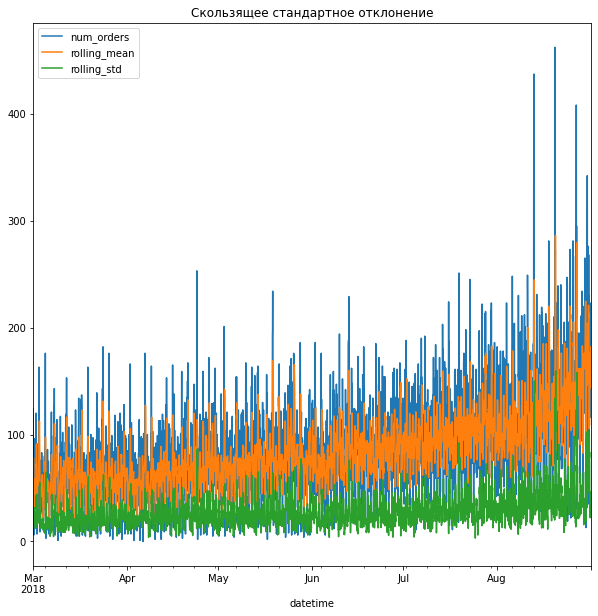

In [13]:
# скользящее среднее (не учитываем текущее значение)
data['rolling_std'] = data['num_orders'].shift().rolling(5).std()
data.plot(figsize=(10,10))
plt.title('Скользящее стандартное отклонение')
plt.show()

У временного ряда меняется среднее и стандартное отклонение, также имеется тренд и сезонность, значит ряд в строгом смысле не стационарный. Однако делать однозначные выводы по графикам мы не будем. Првоерим стационарность ряда тестом Дики-Фуллера.

Нулевая гипотеза ($H_0$) - ряд нестационарен.

Альтернативная гипотеза($H_A$) - ряд стационарен

In [14]:
# тест Дики-Фуллера 

ts = data['num_orders']
st_test = adfuller(ts, regression='ctt')

# возбмем уровень значимости 0.05
# p_value = st_test[1]
if st_test[1] < 0.05:
    print('Отвергаем нулевую гипотезу - наш ряд стационарный')
else:
    print('Нулевая гипотеза не отвергнута - ряд нестационарный')
print('p-value =', st_test[1])

Отвергаем нулевую гипотезу - наш ряд стационарный
p-value = 4.0549397892403547e-17


**Вывод:** В результате анализа нашего временного ряда мы выяснили, что он имеет тренд и сезонную состалвяющую. Ряд в строгом смысле не является стационарным, однако тест Дики-Фуллера показал что ряд - приводимый к стационарному.

Параллельно мы добавили два признака: скользящее среднее и скользящее стандартное отклонение.

## Обучение

Создадим календарные признаки для горизонта прогнозирования.

In [15]:
# день
data['day'] = data.index.day
# час
data['hour'] = data.index.hour
# день недели
data['day_of_week'] = data.index.dayofweek

data.head(10)

,num_orders,rolling_mean,rolling_std,day,hour,day_of_week
datetime,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,1,0,3
2018-03-01 01:00:00,85,NaN,NaN,1,1,3
2018-03-01 02:00:00,71,NaN,NaN,1,2,3
2018-03-01 03:00:00,66,NaN,NaN,1,3,3
2018-03-01 04:00:00,43,NaN,NaN,1,4,3
2018-03-01 05:00:00,6,77.8,29.928248,1,5,3
2018-03-01 06:00:00,12,54.2,30.898220,1,6,3
2018-03-01 07:00:00,15,39.6,29.938270,1,7,3
2018-03-01 08:00:00,34,28.4,25.383065,1,8,3


Создадим признаки с отстающими значениями. Определить количество "лагов" которое будем добавлять нам поможет график автокорреляции. Т.к. мы имеем недельную и суточную сезонность нам важно посмотреть корреляцию лагов в течение недели (7 * 24 = 168 часов).

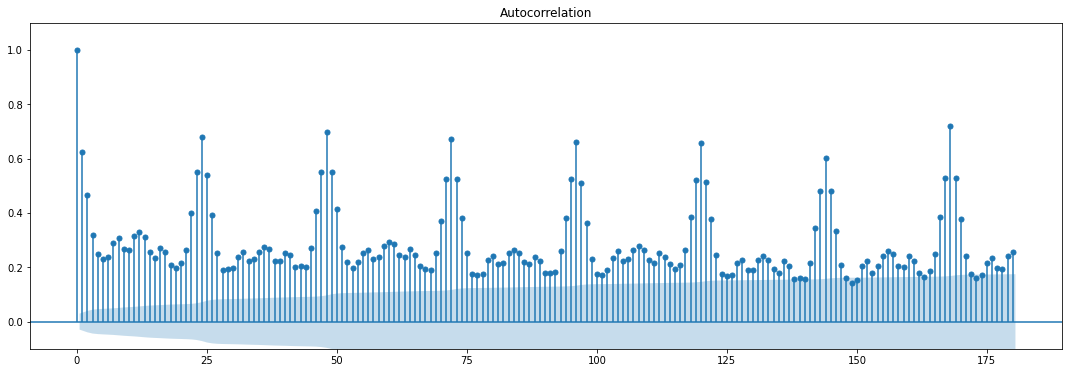

In [16]:
# график автокорелляции

ts = data['num_orders']

fig = tsaplots.plot_acf(ts,lags= 180)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show() 

Видим самую высокую корреляцию с целевым признаком на значении 168. Создадим 168 лагов в нашем датасете.

In [17]:
# отстающие значения
for lag in range(1, 169):
    data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

In [18]:
# удалим пропущенные значения
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4248 entries, 2018-03-08 00:00:00 to 2018-08-31 23:00:00
Freq: H
Columns: 174 entries, num_orders to lag_168
dtypes: float64(170), int64(4)
memory usage: 5.7 MB


In [19]:
# разделение выборки на обучающую итестовую
features = data.drop('num_orders', axis=1)
target = data['num_orders']
features_train, features_test, target_train, target_test = train_test_split(features, target, shuffle=False, test_size=0.1)
print('Размер фрейма признаков обучающей выборки:', features_train.shape)
print('Размер фрейма целевого признака обучающей выборки:', target_train.shape)
print('Размер фрейма признаков тестовой выборки:', features_test.shape)
print('Размер фрейма целевого признака тестовой выборки:', target_test.shape)

Размер фрейма признаков обучающей выборки: (3823, 173)
Размер фрейма целевого признака обучающей выборки: (3823,)
Размер фрейма признаков тестовой выборки: (425, 173)
Размер фрейма целевого признака тестовой выборки: (425,)


In [20]:
# Ridge - регрессия

# используем TimeSeriesSplit т.к. данные надо разделить упорядочено
tscv = TimeSeriesSplit(n_splits=5)

model_ridge = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1],
                      scoring='neg_root_mean_squared_error', cv=tscv)
model_ridge.fit(features_train, target_train)

print(f'RMSE: {model_ridge.best_score_ * -1}')
print(f'Alpha: {model_ridge.alpha_}')

RMSE: 22.724044324135157
Alpha: 1.0


In [24]:
# случайный лес
model_rf = RandomForestRegressor(random_state=96)

param_grid_rf = {
    'n_estimators': range(50, 501, 50),
    'max_depth': range(2, 16),
    'min_samples_split': (2, 3, 4),
    'min_samples_leaf': (1, 2, 3, 4)
}

rs_rf = RandomizedSearchCV(
    model_rf, 
    param_distributions=param_grid_rf, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1, 
    random_state=96,
    cv=tscv
)

rs_rf.fit(features_train, target_train)

print(f'RMSE: {rs_rf.best_score_ * -1}')
print(f'Лучшие параметры: {rs_rf.best_params_}')

RMSE: 22.857565679101377
Лучшие параметры: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 14}


In [22]:
# модель градиентного бустинга
model_boost = CatBoostRegressor(random_state=96, loss_function='RMSE', verbose=False)

param_grid_boost = {
    'iterations': range(10, 301, 10),
    'max_depth': range(2, 16),
    'learning_rate': (0.1, 0.2, 0.3, 0.4)
}

rs_boost = RandomizedSearchCV(
    model_boost, 
    param_distributions=param_grid_boost, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1, 
    random_state=96,
    cv=tscv
)

rs_boost.fit(features_train, target_train)

print(f'RMSE: {rs_boost.best_score_ * -1}')
print(f'Лучшие параметры: {rs_boost.best_params_}')

RMSE: 23.11293747764839
Лучшие параметры: {'max_depth': 2, 'learning_rate': 0.3, 'iterations': 70}


**Вывод:**
Мы создали новые признаки: 
- календарные:  `day`, `day_of_week`, `hour`
- отстающие значения: `lag_1` - `lag_168`


После мы удалили пропущенные значения и разделили исходный датасет на обучающую и тестовую выборки в соотношении: 
- обучающая выборка - 90%
- тестовая выборка - 10%

По итогу были рассмотрены и оценены 3 модели. Расположем их по убыванию метрики RMSE:

1. Ridge-регрессия.
   - RMSE: 22.72
    - Alpha: 1.0
    
    
2. Случайный лес.
    - RMSE: 22.86
    - Лучшие параметры: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 14}


3. Градиентный бустинг.
    - RMSE: 23.11
    - Лучшие параметры: {'max_depth': 2, 'learning_rate': 0.3, 'iterations': 70}

На тестирование выходит модель случайного леса.

## Тестирование

In [25]:
# тестирование лучшей модели случайного леса
prediction_ridge = model_ridge.predict(features_test)
rmse_ridge = mean_squared_error(target_test, prediction_ridge, squared=False)
print(f'RMSE модели ridge-регрессии на тестовой выборке: {rmse_ridge:.2f}')

RMSE модели ridge-регрессии на тестовой выборке: 34.22


Проверим модель на адекватность.

In [26]:
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]
rmse_prev = mean_squared_error(target_test, pred_previous, squared=False)
print(f'RMSE : {rmse_prev:.2f}')

RMSE : 58.82


RMSE полученное нашей моделью ridge-регрессии (34.22) оказалось лучше чем при построении прогноза на основе предыдущих значений (58.82)

**Вывод:** Модель ridge-регрессии с параметрами: {'alpha': 1} на тестовой выборке показала результат 34.22. Также эта модель прошла проверку на адекватность. Берем эту модель в производство.

## Общий вывод

Мы провели исследование исторических данных о заказах такси в аэропортах предоставленные компанией "Четенькое такси". Наша цель - разработать модель для предсказания количества заказов такси на следующий час. Это требовалось для привлечения водителей в период пиковой нагрузки.

В результате подготовки данных сделали следующие:
- ресемплирование по одному часу
- добавили признаки
    - скользящее среднее 
    - скользящее стандартное отклонение
    - день
    - час
    - день недели
    - отстающие значения: lag_1 - lag_168

Проведя анализ данных мы выявили следующие:
- ряд монотонный
- ряд стационарный
- имеется тренд на увеличение заказов такси под конец лета
- имеется сезонная составляющая (посуточная и еженедельная)

Дальше мы создали три модели. 

1. Ridge-регрессия.
   - RMSE (кросс-валидация): 22.72
    - Alpha: 1.0
    - RMSE (тест): 34.22
    
    
2. Случайный лес.
    - RMSE: 22.86
    - Лучшие параметры: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 14}


3. Градиентный бустинг.
    - RMSE: 23.11
    - Лучшие параметры: {'max_depth': 2, 'learning_rate': 0.3, 'iterations': 70}

Модель ridge-регрессии имеет на тестовой выборке значением метрики RMSE не больше 48, таким образом цель выполнена. Данная модель показывает результаты значительно лучшие чем при прогнозировании предыдущим значением. Данная модель пойдет в производство.

Дальнейшие рекомендации:

- Модель ridge-регрессии лучше всех справилась с работой. Потребовалось добавить значительное количество "лагов". Это количество можно посмотреть на графике автокорреляции.

- Графики ряда, скользящего среднего и скользящего стандартного отклонения в некоторых случаях не могут дать однозначную информацию о стационарности ряда. Нужно проводить тест Дики-Фуллера.